<a href="https://colab.research.google.com/github/TheAmirHK/AdeQuaT_Project_AI-and-Optimization/blob/main/SPEA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# In[define the parameters and variables]
INTEGER_INDICES = [0, 1]
CONTINUOUS_INDICES = [2, 3]
BOUNDS = [(1, 10)] * 4

pop_size = 500
generations = 500
MUTATION_RATE = 0.15
CROSSOVER_RATE = 0.92

In [ ]:
# In[define the objective functions]
def evaluate(individual):
    x1, x2, x3, x4 = individual
    obj1 = x1**2 + 2*x2**2 - 4*x3**2 + 11*x4**3  # minimize
    obj2 = -(x1 - 2*x2**3 - 10*x3**2 - 11*x4**2 + x1*x2)  # maximize
    obj3 = x1*x2 + x3**2 - 5*x4  # minimize
    return obj1, obj2, obj3

In [ ]:
# In[define the constraints]
def constraints(individual):
    x1, x2, x3, x4 = individual
    return (x1 + x2 <= 5) and (x3**2 + x4**2 - x2*x1*x3 <= 20)

In [ ]:
# In[check if fitness values fit1 dominate fit2]
def dominates(fit1, fit2):
    return all(x <= y for x, y in zip(fit1, fit2)) and any(x < y for x, y in zip(fit1, fit2))

In [ ]:
# In[mutation and crossover]
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            if i in INTEGER_INDICES:
                individual[i] = random.randint(*BOUNDS[i])
            else:
                individual[i] += random.uniform(-0.5, 0.5)
                individual[i] = max(BOUNDS[i][0], min(BOUNDS[i][1], individual[i]))
    return individual

In [ ]:
# In[non-dominated sorting action to create Pareto fronts]
def non_dominated_sort(population, fitness_values):
    fronts = [[]]
    dom_count = {}
    dom_set = {}

    for i, fit in enumerate(fitness_values):
        dom_set[i] = []
        dom_count[i] = 0
        for j, other_fit in enumerate(fitness_values):
            if dominates(fit, other_fit):
                dom_set[i].append(j)
            elif dominates(other_fit, fit):
                dom_count[i] += 1
        if dom_count[i] == 0:
            fronts[0].append(i)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for i in fronts[current_front]:
            for j in dom_set[i]:
                dom_count[j] -= 1
                if dom_count[j] == 0:
                    next_front.append(j)
        current_front += 1
        fronts.append(next_front)
    return fronts[:-1]

In [ ]:
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]
        for i in INTEGER_INDICES:
            child1[i] = int(round(child1[i]))
            child2[i] = int(round(child2[i]))
        return child1, child2
    return parent1, parent2

In [ ]:
# In[fitness assignment and selection]
def calculate_fitness(population, fitness_values):
    fitness_values = np.array(fitness_values)
    strength = np.zeros(len(population))
    raw_fitness = np.zeros(len(population))
    density = np.zeros(len(population))

    for i, fit in enumerate(fitness_values):
        for j, other_fit in enumerate(fitness_values):
            if dominates(fit, other_fit):
                strength[i] += 1

    for i, fit in enumerate(fitness_values):
        for j, other_fit in enumerate(fitness_values):
            if dominates(other_fit, fit):
                raw_fitness[i] += strength[j]

    distance_matrix = np.linalg.norm(fitness_values[:, np.newaxis, :] - fitness_values[np.newaxis, :, :], axis=2)
    sorted_distances = np.sort(distance_matrix, axis=1)
    density = 1 / (sorted_distances[:, 1] + 2)

    return raw_fitness + density

In [ ]:
def select_parents(population, fitness, num_parents):
    selected = []
    for _ in range(num_parents):
        i, j = random.sample(range(len(population)), 2)
        selected.append(population[i] if fitness[i] < fitness[j] else population[j])
    return selected

In [ ]:
# In[SPEA2 implementation]
def SPEA2(pop_size, generations):
    population = [list((random.randint(1, 10), random.randint(1, 10), random.uniform(1, 10), random.uniform(1, 10)))
                  for _ in range(pop_size)]
    archive = []

    for gen in tqdm(range(generations)):
        fitness_values = np.array([evaluate(ind) for ind in population])
        feasible_population = [ind for ind, fit in zip(population, fitness_values) if constraints(ind)]
        feasible_fitness = [fit for ind, fit in zip(population, fitness_values) if constraints(ind)]

        fitness = calculate_fitness(feasible_population, feasible_fitness)
        sorted_indices = np.argsort(fitness)
        archive = [feasible_population[i] for i in sorted_indices[:pop_size]]

        parents = select_parents(archive, fitness, pop_size)
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = random.sample(parents, 2)
            c1, c2 = crossover(p1, p2)
            offspring.extend([mutate(c1), mutate(c2)])

        population = offspring[:pop_size]

    final_fitness = [evaluate(ind) for ind in population]
    final_fronts = non_dominated_sort(population, final_fitness)
    pareto_front = [population[i] for i in final_fronts[0]]
    pareto_fitness = [final_fitness[i] for i in final_fronts[0]]

    return pareto_front, pareto_fitness, final_fitness

In [ ]:
# In[plot Pareto front]
def plot_pareto(pareto_fitness, all_fitness):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    all_fitness = np.array(all_fitness)
    pareto_fitness = np.array(pareto_fitness)

    ax.view_init(elev=10, azim=-150)
    ax.scatter(all_fitness[:, 0], all_fitness[:, 1], all_fitness[:, 2], color='gray', alpha=0.5, label='All Feasible Solutions')
    ax.scatter(pareto_fitness[:, 0], pareto_fitness[:, 1], pareto_fitness[:, 2], c='r', marker='o', label='Pareto Front')

    ax.set_xlabel("Min Obj 1")
    ax.set_ylabel("Max Obj 2")
    ax.set_zlabel("Min Obj 3")
    ax.set_title("Pareto Front")
    plt.legend()
    plt.show()

100%|██████████| 500/500 [04:07<00:00,  2.02it/s]


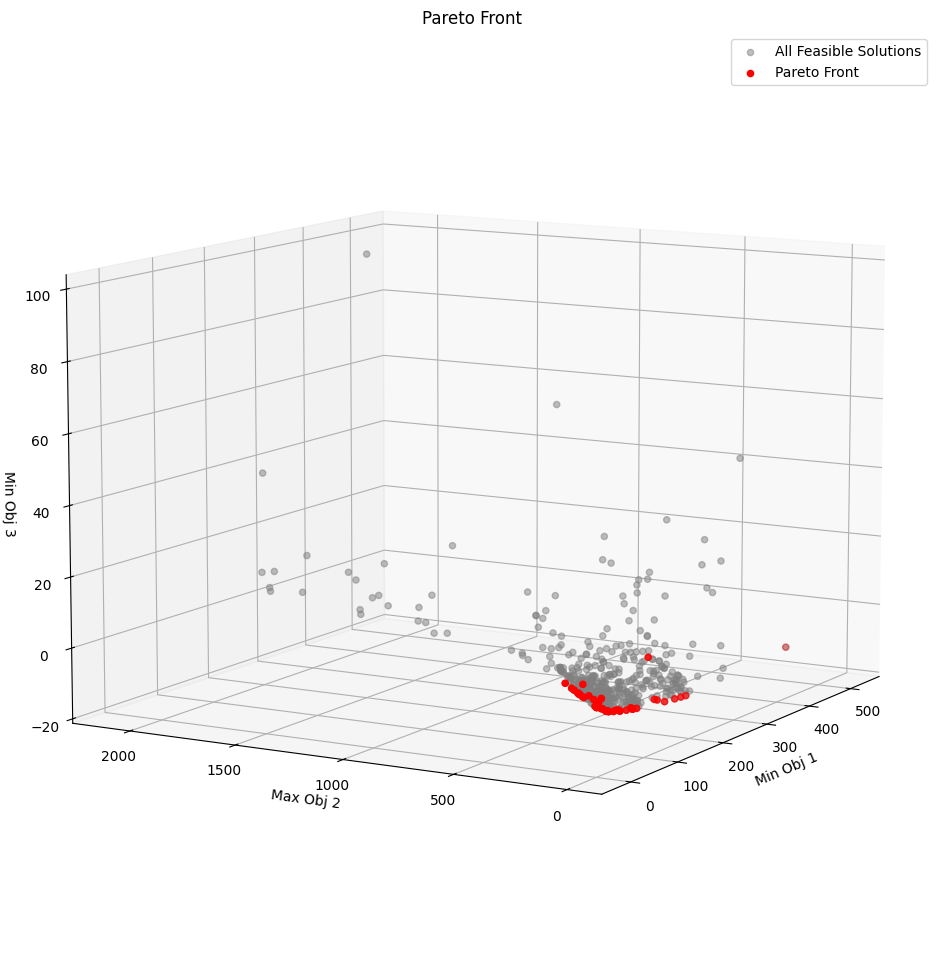

In [ ]:
if __name__ == "__main__":
    pareto_front, pareto_fitness, all_fitness = SPEA2(pop_size, generations)
    plot_pareto(pareto_fitness, all_fitness)